# 10-1. 들어가며

![](https://d3s0tskafalll9.cloudfront.net/media/images/68747470733a2f2f.max-800x600.png)

이번 시간에는 **Semantic Segmentation(시맨틱 세그멘테이션)**을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보는 시간을 갖겠습니다. 앞서 강의 노드에서는 Semantic Segmentation을 위한 다양한 모델을 배워보았습니다. 이번 시간에는 U-Net을 사용해서 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어보겠습니다.

최종적으로 만들어 볼 모델은 아래와 같습니다! 입력 이미지 위에 도로 영역으로 인식한 영역을 흰색으로 오버레이 한 이미지입니다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/result.gif)

## 실습목표
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

## 학습내용
1. 시맨틱 세그멘테이션 데이터셋
1. 시맨틱 세그멘테이션 모델
1. 시맨틱 세그멘테이션 모델 시각화






# 10-2. 시맨틱 세그멘테이션 데이터셋
## 이미지, 데이터 가져오기
먼저 **시맨틱 세그멘테이션(semantic segmentation)**으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱 해야 합니다. 아래 링크를 통해서 물체 검출(object detection)으로 사용했던 **KITTI 데이터셋의 세그멘테이션 데이터**를 다운로드합니다.

데이터 출처: http://www.cvlibs.net/datasets/kitti/eval_semantics.php

`cloud shell`에서 아래 명령어를 실행해 주세요

```
$ mkdir -p ~/aiffel/semantic_segmentation/data
$ ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/
```
아래는 데이터셋에서 확인할 수 있는 이미지와 라벨입니다. 지금까지 보던 라벨 데이터와 다르게 세그멘테이션 데이터는 이미지 형태의 라벨로 되어있습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10.max-800x600.png)

![](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10_label.max-800x600.png)

![](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10_mqPgQu0.max-800x600.png)

## 데이터 로더(data loader) 만들기
이제 이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어봅시다. 로더는 입력값 `(224, 224)`, 출력값 `(224, 244)` 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 해야 합니다.

이때 데이터 로더에 **augmentation**을 적용해 봅시다. 오늘은 파이썬에서 많이 사용되는 `albumentations`을 사용해 보겠습니다. 하지만 Augmentation의 경우 `imgaug` 등 다른 라이브러리를 활용하셔도 됩니다.

```
$ pip list | grep albumentations
```

또한 학습셋의 일정량을 **검증 데이터셋(validation dataset)**으로 활용할 수 있도록 해야 합니다.

구현을 할 때는 아래 자료를 참고해 보세요.

- [Keras Sequence에 기반한 Dataloader](https://hwiyong.tistory.com/241)
- [Albumentation을 적용한 Keras sequence](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)

만든 후에는 직접 데이터셋이 잘 파싱 되어 나오는지 꼭 확인해보세요. 데이터셋에 오류가 없어야 성능이 안 나오더라도 문제를 찾아내기 쉽습니다.





In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


Albumentation 의 사용법을 간단히 알아보겠습니다. 아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 `Compose()`의 활용예입니다. imgaug의 `Sometimes()`와 유사한 기능입니다.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                  Resize(
                      width=224,
                      height=224
                      )
                  ])

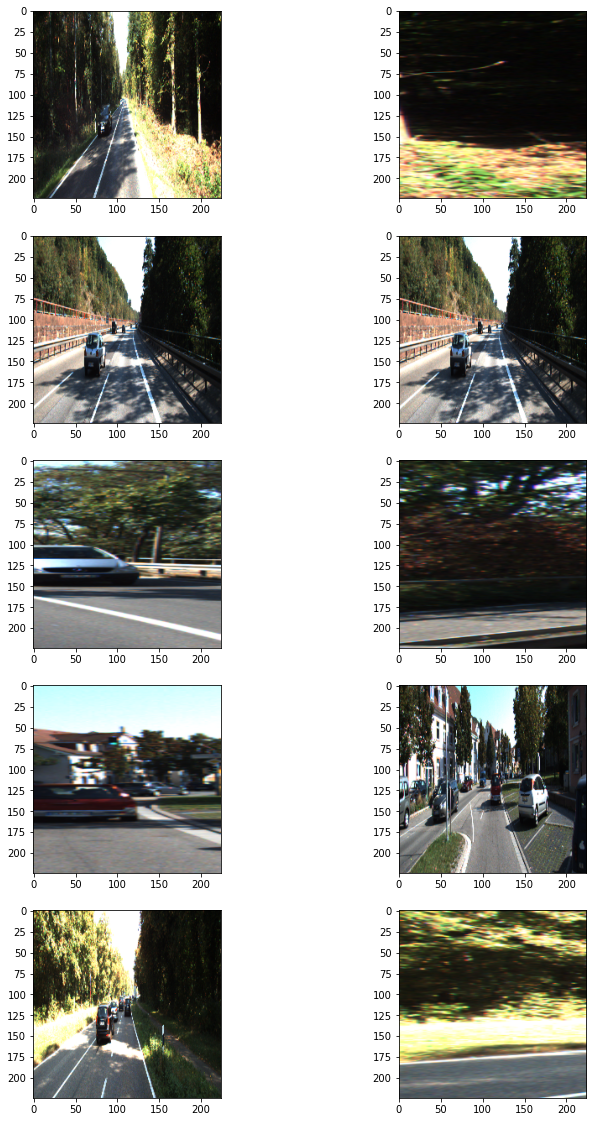

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

이제 데이터셋을 구성해 봅시다. 이번에는 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 보겠습니다.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 10-3. 시맨틱 세그멘테이션 모델

![](https://d3s0tskafalll9.cloudfront.net/media/images/u-net_1kfpgqE.max-800x600.png)

## 모델 구조 만들기
시맨틱 세그멘테이션을 위한 모델을 만들어주세요. 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 `U-Net`을 구현해 봅시다.

이때 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어주세요.

사용에 필요한 레이어와 연산은 다음과 같습니다. 그리고 필요에 따라서 Dropout 등의 다른 레이어를 적용해 보세요.

- **`Conv2D`**, **`Conv2DTranspose`**, **`MaxPooling2D`**, **`concatenate`**


In [6]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
	
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_0_conv1')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_0_conv2')(conv0_0)
    
    pool1_0 = MaxPooling2D(pool_size=(2, 2), name='X_1_0_pool')(conv0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_0_conv1')(pool1_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_0_conv2')(conv1_0)
    
    pool2_0 = MaxPooling2D(pool_size=(2, 2), name='X_2_0_pool')(conv1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_0_conv1')(pool2_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_0_conv2')(conv2_0)

    pool3_0 = MaxPooling2D(pool_size=(2, 2), name='X_3_0_pool')(conv2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_0_conv1')(pool3_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_0_conv2')(conv3_0)
    drop3_0 = Dropout(0.5, name='X_3_0_DO')(conv3_0)

    pool4_0 = MaxPooling2D(pool_size=(2, 2), name='X_4_0_pool')(drop3_0)
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_4_0_conv1')(pool4_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_4_0_conv2')(conv4_0)
    drop4_0 = Dropout(0.5, name='X_4_0_DO')(conv4_0)
    
    

    up3_1 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_4_0_up')(drop4_0)
    merge3_1 = concatenate([drop3_0,up3_1], axis = 3, name='X_3_1_merge')
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_1_conv1')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_1_conv2')(conv3_1)

    up2_2 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_3_1_up')(conv3_1)
    merge2_2 = concatenate([conv2_0,up2_2], axis = 3, name='X_2_2_merge')
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_2_conv1')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_2_conv2')(conv2_2)

    up1_3 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_2_2_up')(conv2_2)
    merge1_3 = concatenate([conv1_0,up1_3], axis = 3, name='X_1_3_merge')
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_3_conv1')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_3_conv2')(conv1_3)

    up0_4 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_1_3_up')(conv1_3)
    merge0_4 = concatenate([conv0_0,up0_4], axis = 3, name='X_0_4_merge')
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv1')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv2')(conv0_4)  
    conv0_4 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv3')(conv0_4)     

    outputs = Conv2D(1, 1, activation='sigmoid', name='output')(conv0_4)

    model = Model(inputs = inputs, outputs = outputs)
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    return model

!pip install -U tensorboard

!rm -rf ./logs/

from datetime import datetime
import tensorboard

# Load the TensorBoard notebook extension.
%load_ext tensorboard

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## 모델 학습하기
이제 모델을 만들었으니 위에서 만들어본 데이터셋과 학습을 해봅시다! 적절한 learning rate와 epoch를 찾아서 모델을 학습하고 저장해 주세요. (모델 학습에 상당한 시간이 소요됨으로 학습이 잘 진행되는지 확인해 보시고 다음 스텝으로 넘어가셔서 이미 학습된 모델을 사용하셔도 됩니다.)

In [15]:
EPOCHS = 100

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model_unet = build_unet()
model_unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_unet.fit(
    x=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    #callbacks=[tensorboard_callback]
 )

model_unet.save(model_path)  #학습한 모델을 저장해 주세요.


Epoch 1/100
11/11 [==============================] - 15s 1s/step - loss: 0.6874 - val_loss: 0.6691
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.6053 - val_loss: 0.0569
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.0407 - val_loss: 0.0318
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 0.0551 - val_loss: 0.0396
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.0365 - val_loss: 0.0301
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0362 - val_loss: 0.0328
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0302 - val_loss: 0.0328
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.0334 - val_loss: 0.0280
Epoch 9/100
11/11 [==============================] - 13s 1s/step - loss: 0.0259 - val_loss: 0.0268
Epoch 10/100
11/11 [==============================] - 12s 1s/step - loss: 0.0256 - val_loss: 0.0226
Epoch 11/

11/11 [==============================] - 13s 1s/step - loss: 0.0131 - val_loss: 0.0212
Epoch 84/100
11/11 [==============================] - 13s 1s/step - loss: 0.0150 - val_loss: 0.0210
Epoch 85/100
11/11 [==============================] - 13s 1s/step - loss: 0.0158 - val_loss: 0.0210
Epoch 86/100
11/11 [==============================] - 13s 1s/step - loss: 0.0132 - val_loss: 0.0237
Epoch 87/100
11/11 [==============================] - 13s 1s/step - loss: 0.0180 - val_loss: 0.0216
Epoch 88/100
11/11 [==============================] - 13s 1s/step - loss: 0.0149 - val_loss: 0.0209
Epoch 89/100
11/11 [==============================] - 13s 1s/step - loss: 0.0169 - val_loss: 0.0238
Epoch 90/100
11/11 [==============================] - 13s 1s/step - loss: 0.0170 - val_loss: 0.0216
Epoch 91/100
11/11 [==============================] - 13s 1s/step - loss: 0.0158 - val_loss: 0.0216
Epoch 92/100
11/11 [==============================] - 13s 1s/step - loss: 0.0161 - val_loss: 0.0225
Epoch 93/100


!tensorboard dev upload --logdir logs \
    --name "Unet" \
    --description "for Semantic Segmentation"

아이펠 클라우드에서 텐서보드가 제대로 작동이 안 된다..

코랩에서 따로 확인해서 모델 구조 이미지만 첨부

[Tensorboard Dev](https://tensorboard.dev/experiment/xVYxwSB3QJe8mA93u5UydQ/#graphs&run=fit%2F20211024-153947%2Ftrain)

소량의 이미지로 모델 구조만 확인한거라 Scalars 는 무관!

name을 X(m,n) 꼴로 만들고 싶었는데 왜인지 name 에서 (m,n) 꼴이 인식이 안됨 ㅠ

![fit_20211024-153947_train](https://user-images.githubusercontent.com/86637242/138602257-5419dfcb-7f00-49a2-97be-65e7c9c3ea0b.png)


# 10-4. 시맨틱 세그멘테이션 모델 시각화

이번에는 학습한 모델의 결과를 눈으로 확인해 볼 차례입니다. 우선 이전 스텝에서 저장한 모델이나 제공된 모델을 다음 코드를 통해 불러와 주세요.

In [16]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
#model_path = dir_path + '/seg_model_unet.h5' 

model_unet = tf.keras.models.load_model(model_path)

테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어주세요!

이때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 **오버레이(overray)** 해 주세요. PIL 패키지를 사용하신다면 `Image.blend`를 활용하실 수 있습니다.

`get_output`이라는 이름의 함수로 만들어 주세요.

In [17]:
def get_output(model, preproc, image_path, output_path):
    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 

위에서 작성한 함수를 이용해 시각화를 해봅시다.

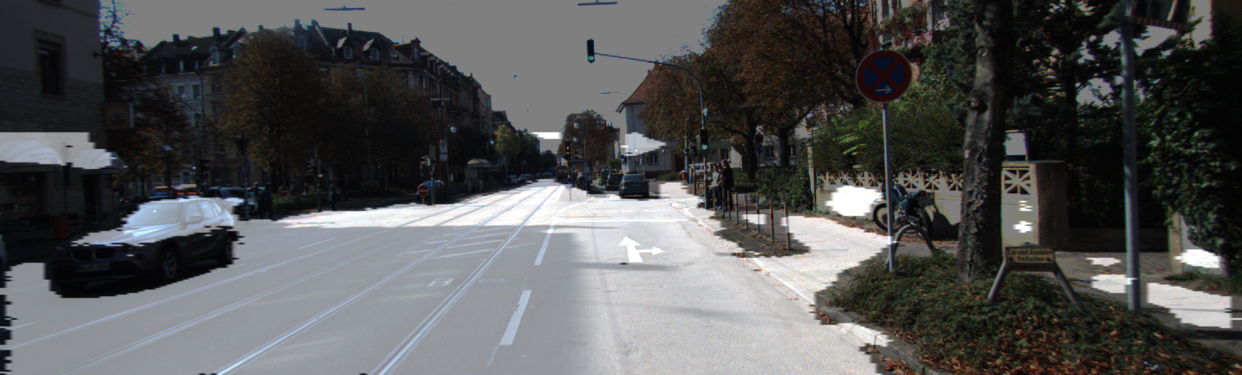

In [18]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다. IoU를 계산하는 방법은 지난 시간에 소개한 바 있으므로 해당 내용을 활용하여 구현해 보겠습니다.

IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 각각을 `prediction`, `target`이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다. 위에 구현했던 `get_output`을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [19]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [20]:
def get_output2(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
        output.show()   # 도로로 판단한 영역을 시각화!

        return output, prediction, target
    else:
        output.show()   # 도로로 판단한 영역을 시각화!
        return output, prediction, _

In [21]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

IoU : 0.808458


0.8084575480990216

# 10-5. 프로젝트 : 개선된 U-Net 모델 만들기
U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느 정도 동작하는 것 같긴 하지만 좀 더 개선할 여지도 보일 것입니다.

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.

그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일이미지에 대한 IoU 값을 비교해 보면 될 것입니다.

- [U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)



### Step 1. KITTI 데이터셋 수집과 구축
다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습 데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.


In [22]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    batch_size=4,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=4,
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.

그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.


In [23]:
def build_unet_pp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
	
    # X(0,0)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_0_conv1')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_0_conv2')(conv0_0)
    
    # X(1,0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2), name='X_1_0_pool')(conv0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_0_conv1')(pool1_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_0_conv2')(conv1_0)
    
    # X(0,1)
    up0_1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_1_up')(conv1_0)
    merge0_1 = concatenate([conv0_0,up0_1], axis = 3, name='X_0_1_merge')
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_1_conv1')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_1_conv2')(conv0_1)

    # X(2,0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2), name='X_2_0_pool')(conv1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_0_conv1')(pool2_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_0_conv2')(conv2_0)

    # X(1,1)
    up1_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_1_1_up')(conv2_0)
    merge1_1 = concatenate([conv1_0,up1_1], axis = 3, name='X_1_1_merge')
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_1_conv1')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_1_conv2')(conv1_1)

    # X(0,2)
    up0_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_2_up')(conv1_1)
    merge0_2 = concatenate([conv0_0,conv0_1,up0_2], axis = 3, name='X_0_2_merge')
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_2_conv1')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_2_conv2')(conv0_2)

    # X(3,0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2), name='X_3_0_pool')(conv2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_0_conv1')(pool3_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_0_conv2')(conv3_0)
    drop3_0 = Dropout(0.5, name='X_3_0_DO')(conv3_0)

    # X(2,1)
    up2_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_2_1_up')(conv3_0)
    merge2_1 = concatenate([conv2_0,up2_1], axis = 3, name='X_2_1_merge')
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_1_conv1')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_1_conv2')(conv2_1)

    # X(1,2)
    up1_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_1_2_up')(conv2_1)
    merge1_2 = concatenate([conv1_0,conv1_1,up1_2], axis = 3, name='X_1_2_merge')
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_2_conv1')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_2_conv2')(conv1_2)

    # X(0,3)
    up0_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_3_up')(conv1_2)
    merge0_3 = concatenate([conv0_0,conv0_1,conv0_2,up0_3], axis = 3, name='X_0_3_merge')
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_3_conv1')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_3_conv2')(conv0_3)

    # X(4,0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2), name='X_4_0_pool')(drop3_0)
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_4_0_conv1')(pool4_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_4_0_conv2')(conv4_0)
    drop4_0 = Dropout(0.5, name='X_4_0_DO')(conv4_0)

    # X(3,1)
    up3_1 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_3_1_up')(drop4_0)
    merge3_1 = concatenate([drop3_0,up3_1], axis = 3, name='X_3_1_merge')
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_1_conv1')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_1_conv2')(conv3_1)

    # X(2,2)
    up2_2 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_2_2_up')(conv3_1)
    merge2_2 = concatenate([conv2_0,conv2_1,up2_2], axis = 3, name='X_2_2_merge')
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_2_conv1')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_2_conv2')(conv2_2)

    # X(1,3)
    up1_3 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_1_3_up')(conv2_2)
    merge1_3 = concatenate([conv1_0,conv1_1,conv1_2,up1_3], axis = 3, name='X_1_3_merge')
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_3_conv1')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_3_conv2')(conv1_3)

    # X(0,4)
    up0_4 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_4_up')(conv1_3)
    merge0_4 = concatenate([conv0_0,conv0_1,conv0_2,conv0_3,up0_4], axis = 3, name='X_0_4_merge')
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv1')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv2')(conv0_4)  
    conv0_4 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv3')(conv0_4)     

    outputs = Conv2D(1, 1, activation='sigmoid', name='output')(conv0_4)

    model = Model(inputs = inputs, outputs = outputs)
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    return model

In [24]:
model_path_pp = '/content/drive/MyDrive/Colab/aiffel/semantic_segmentation/seg_model_unet_pp.h5'

model_unet_pp = build_unet_pp()
model_unet_pp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_unet_pp.fit(
    x=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    #callbacks=[tensorboard_callback]
 )

model_unet_pp.save(model_path_pp)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 114s 2s/step - loss: 0.5700 - val_loss: 0.1706
Epoch 2/100
43/43 [==============================] - 67s 2s/step - loss: 0.1680 - val_loss: 0.1384
Epoch 3/100
43/43 [==============================] - 67s 2s/step - loss: 0.1354 - val_loss: 0.1388
Epoch 4/100
43/43 [==============================] - 68s 2s/step - loss: 0.1365 - val_loss: 0.1120
Epoch 5/100
43/43 [==============================] - 67s 2s/step - loss: 0.0965 - val_loss: 0.1092
Epoch 6/100
43/43 [==============================] - 67s 2s/step - loss: 0.1101 - val_loss: 0.1042
Epoch 7/100
43/43 [==============================] - 67s 2s/step - loss: 0.0862 - val_loss: 0.0960
Epoch 8/100
43/43 [==============================] - 67s 2s/step - loss: 0.0824 - val_loss: 0.1018
Epoch 9/100
43/43 [==============================] - 67s 2s/step - loss: 0.0761 - val_loss: 0.0822
Epoch 10/100
43/43 [==============================] - 68s 2s/step - loss: 0.1002 - val_loss: 0.1176
Epoch 11

43/43 [==============================] - 67s 2s/step - loss: 0.0483 - val_loss: 0.0641
Epoch 84/100
43/43 [==============================] - 67s 2s/step - loss: 0.0533 - val_loss: 0.0666
Epoch 85/100
43/43 [==============================] - 67s 2s/step - loss: 0.0580 - val_loss: 0.0692
Epoch 86/100
43/43 [==============================] - 67s 2s/step - loss: 0.0547 - val_loss: 0.0648
Epoch 87/100
43/43 [==============================] - 67s 2s/step - loss: 0.0556 - val_loss: 0.0664
Epoch 88/100
43/43 [==============================] - 67s 2s/step - loss: 0.0526 - val_loss: 0.0646
Epoch 89/100
43/43 [==============================] - 67s 2s/step - loss: 0.0539 - val_loss: 0.0918
Epoch 90/100
43/43 [==============================] - 67s 2s/step - loss: 0.0523 - val_loss: 0.0654
Epoch 91/100
43/43 [==============================] - 67s 2s/step - loss: 0.0446 - val_loss: 0.0607
Epoch 92/100
43/43 [==============================] - 67s 2s/step - loss: 0.0457 - val_loss: 0.0705
Epoch 93/100


생각만큼 그래프 모양이 예쁘게 나오지는 않았다 .. ㅠㅠ

레이어들을 합쳐보고 싶은데 잘 안 됨.. ㅠㅠ

[Tensorboard](https://tensorboard.dev/experiment/NVs0fABAR1q0D61bIxp9Zg/#graphs&run=fit%2F20211024-160309%2Ftrain)

![fit_20211024-160309_train](https://user-images.githubusercontent.com/86637242/138602449-33710bb8-906a-4231-985b-892703e9fb12.png)


### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

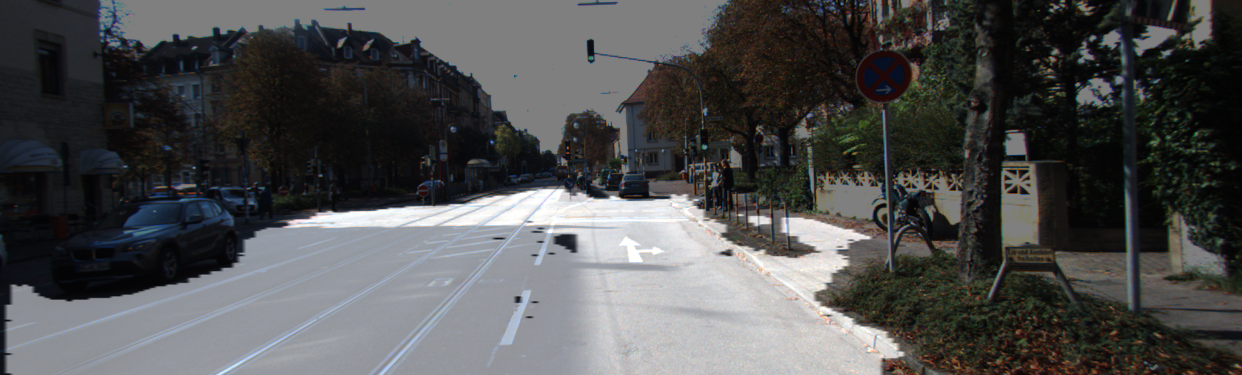

In [25]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [26]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model_unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

IoU : 0.888504


0.8885037976550402